#### Initial Data Loading and Cleaning

In [2]:
### Cleaning up data ###
import pandas as pd
import numpy as np

df = pd.read_csv('data/AirQualityUCI.csv', sep=';')

# Create timestamps
df.insert(0, 'Timestamp', pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S'))

# Drop useless columns
df = df.drop(['Unnamed: 15', 'Unnamed: 16', 'Date', 'Time'], axis=1)

# Columns to floats
for col in df.columns.drop('Timestamp'):
    df[col] = df[col].map(lambda x: float(str(x).replace(',', '.')))
    
# Add NaNs instead of 200
df = df.replace(-200, np.nan)

# Remove useless columns at end
df = df.loc[~pd.isnull(df['Timestamp']), :]

# Nice alternative dataframe with timestamps as index
df_ts = df.set_index('Timestamp', drop=True)

df.to_excel('output_data/cleaned.xlsx')

#### Exploratory Data Analysis

DatetimeIndex([], dtype='datetime64[ns]', freq='h')
2416 9357
                 Timestamp       CO(GT)  PT08.S1(CO)     NMHC(GT)  \
count                 9357  7674.000000  8991.000000   914.000000   
mean   2004-09-21 16:00:00     2.152750  1099.833166   218.811816   
min    2004-03-10 18:00:00     0.100000   647.000000     7.000000   
25%    2004-06-16 05:00:00     1.100000   937.000000    67.000000   
50%    2004-09-21 16:00:00     1.800000  1063.000000   150.000000   
75%    2004-12-28 03:00:00     2.900000  1231.000000   297.000000   
max    2005-04-04 14:00:00    11.900000  2040.000000  1189.000000   
std                    NaN     1.453252   217.080037   204.459921   

          C6H6(GT)  PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)      NO2(GT)  \
count  8991.000000    8991.000000  7718.000000   8991.000000  7715.000000   
mean     10.083105     939.153376   246.896735    835.493605   113.091251   
min       0.100000     383.000000     2.000000    322.000000     2.000000   
25%     

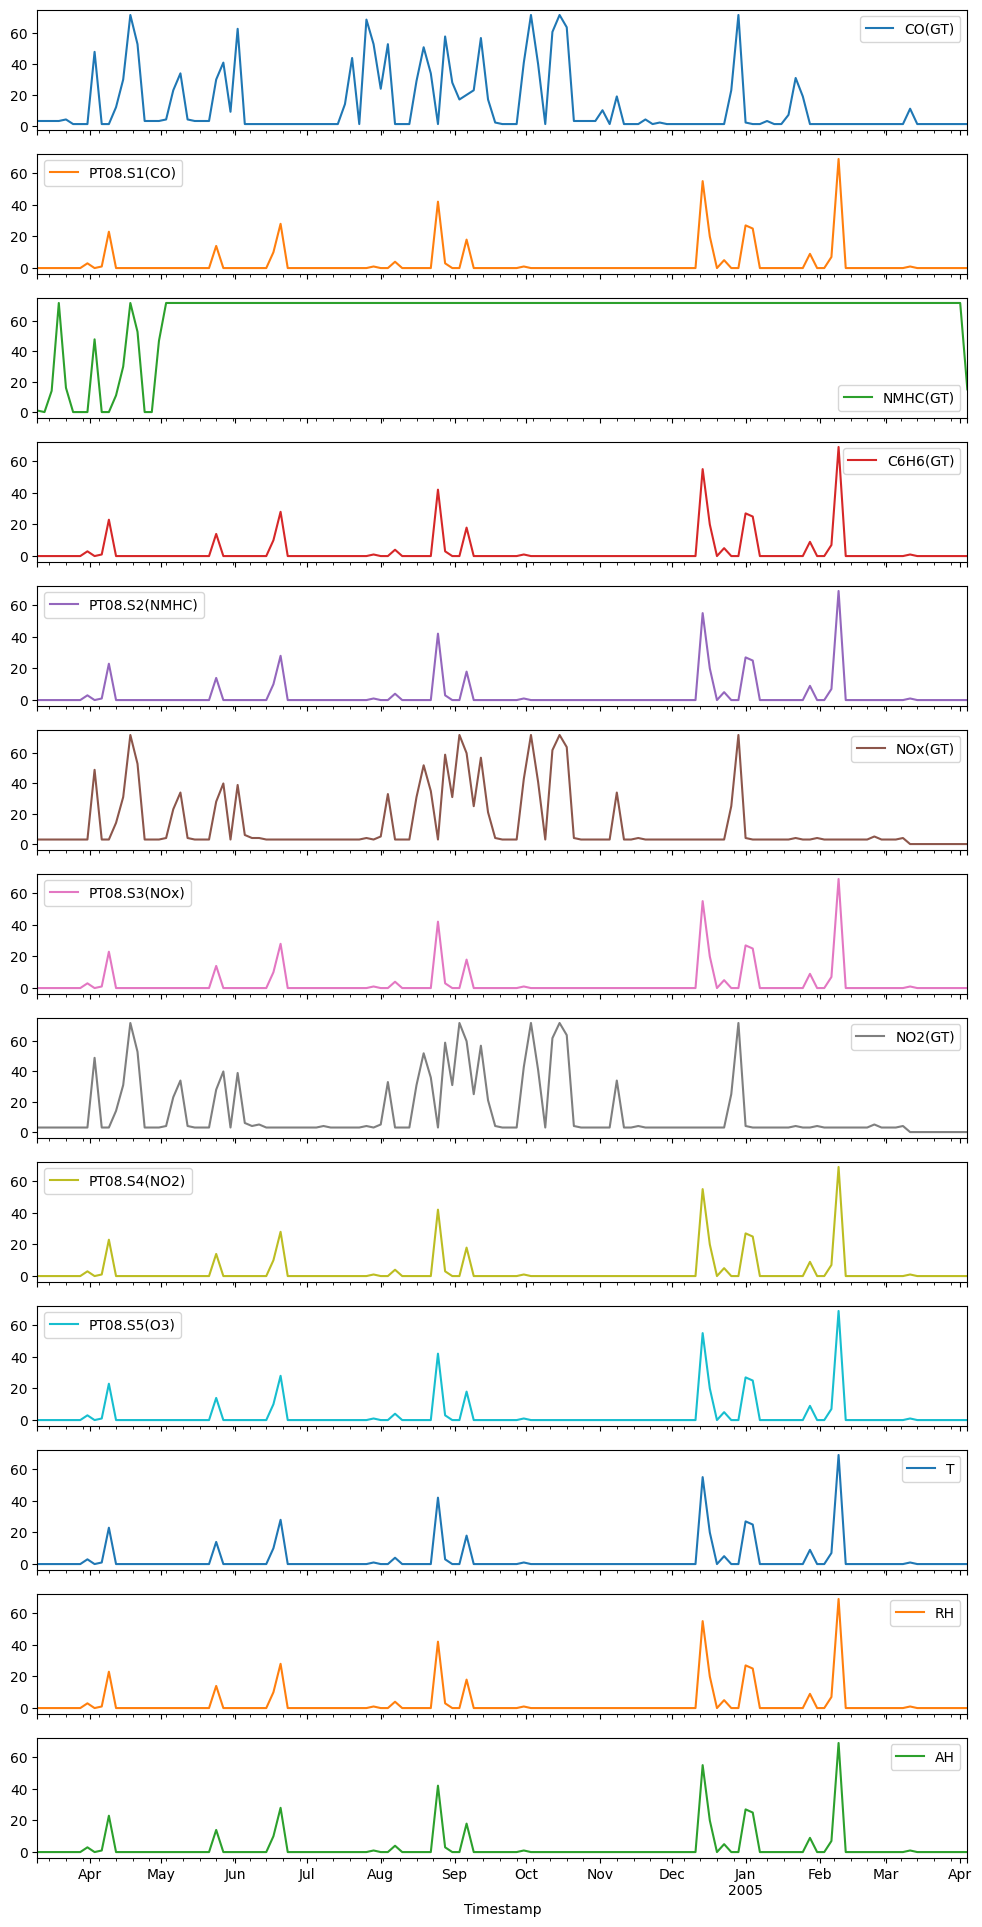

In [35]:
### Basic Data Properties - Missing Values ###

# Check no missing timestamps
expected_timestamps = pd.date_range(start=df['Timestamp'].min(), end=df['Timestamp'].max(), freq='1h')
missing_timestamps = expected_timestamps.difference(df['Timestamp'])
print(missing_timestamps) # empty

# What happens to missing timestamps if drop na. Omit the column which is all NA after a while
dropts = df.drop(['NMHC(GT)'], axis=1).dropna()['Timestamp']
drop_expected_timestamps = pd.date_range(start=dropts.min(), end=dropts.max(), freq='1h')
drop_missing_timestamps = expected_timestamps.difference(dropts)
print(len(drop_missing_timestamps), len(df['Timestamp'])) # 2k cols -> quarter of data

# From examining the excel file, it seems that the standard situation for 
# missing data is a measurement cutting out for a continuous series of hours (often exactly 24 or 48 hours)
# - perhaps sensors were turned off

# basic summaries, mainly for missing values
print(df.describe())
print("Percentage of missing values:\n", (df.isna().sum() / len(df) * 100).round(2))
# data starts at 2004-03. Ends at 2005-04 - very close to one year.
# All the PT sensors have similar standard deviations ranging from 200 to 400
# The sensor columns all have 8991 non NaN values - very rarely cut out, and when they do its all at the same time. I think T, RH, AH also cut out at exactly the same time
# Ground truth colums have around 7.5k non NaN values for all of them except NMHC which cuts out after about 1000 measurements.
# Missing value percentages: 4% for the 8991 cols, 17% consistently for GT columns except for NMHC (90%)

# Plots of missing values over time
day_miss_counts = df_ts.resample('3D').apply(lambda x: x.isna().sum())
plt = day_miss_counts.plot(kind='line', figsize=(12,24), subplots=True)

# Takeaways
# PT08 + meteorogical sensors go missing at exactly the same time                                 
# NOx and NO2 GT stations go missing at exactly same time - seem to be same device.
# CO(GT) also goes missing often
# The spikes are to at least 20. This means that when things go missing it is usually
# for a long period of time. If pollutant measurements change significantly throughout
# the day, imputing using just the mean is probably a bad idea over such long timespans.
# Some other approach would have to be used.
# Ground truth station have frequent spikes up to 60, indicating entire 3 day sections
# missing. Will have to think about how to impute

# If we decide to drop sections with too many missing values, we will have to think about 
# how our model handles jumps in time. Need this when developing our time features




AttributeError: 'Series' object has no attribute 'hours'

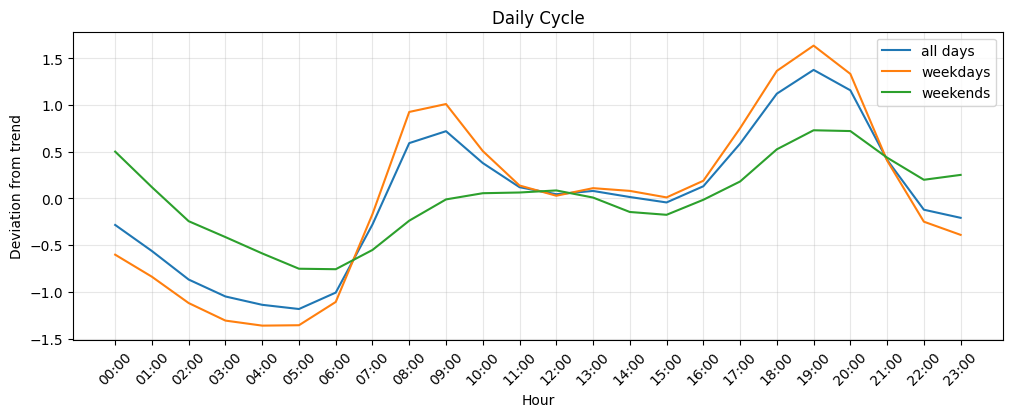

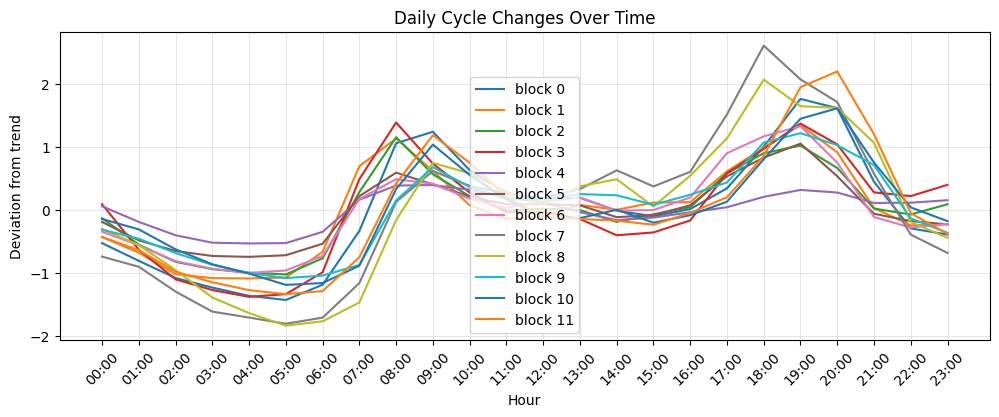

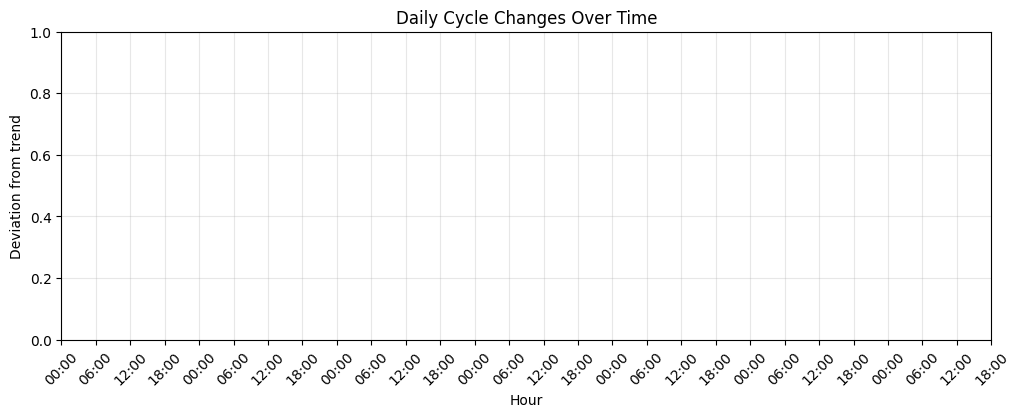

In [ ]:
### Univariate Time Series Analysis ###
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

## Day averages over time and Rolling Windows over Time
# day_avgs = df_ts.resample('10D').apply(lambda x: x.mean())
# dplt = day_avgs.plot(kind='line', figsize=(12,36), subplots=True)

# df_rolling = df_ts.rolling('D', min_periods=12).mean()
# fig, ax = plt.subplots(figsize=(15,25))
# dplt = df_rolling.plot(kind='line', figsize=(12,36), ax=ax, subplots=True)

# ## Correspondence of normalised sensor and ground truth readings
# df_normalised = df_ts.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
# df_normalised_resampled = df_normalised.resample('1D').apply(lambda x: x.mean())

# sensor_plots_fig, sensor_plots_ax = plt.subplots(4, 1, figsize=(20,15))
# for cols, ax in zip([
#     ['CO(GT)', 'PT08.S1(CO)'],
#     ['NMHC(GT)', 'PT08.S2(NMHC)'],
#     ['NOx(GT)', 'PT08.S3(NOx)'],
#     ['NO2(GT)', 'PT08.S4(NO2)'],
# ], sensor_plots_ax):
#     df_normalised_resampled[cols].plot(kind='line', ax=ax)
    
# ## Histograms ##
# fig, ax = plt.subplots(figsize=(15,15), constrained_layout=True)
# df_ts.hist(bins=50, ax=ax)

## Seasonal Decompositions ##

# ** CO(GT) **
# overall daily cycle, weekend daily cycle, weekday daily cycle
period=24 # number of hours in period (24=day, 168=week)
co_series = df_ts['CO(GT)'].interpolate(method='time')
decomp_full = seasonal_decompose(co_series, model='additive', period=period)
decomp_weekday = seasonal_decompose(co_series[co_series.index.weekday < 5], model='additive', period=period)
decomp_weekend = seasonal_decompose(co_series[co_series.index.weekday >= 5], model='additive', period=period)
one_cycle = decomp_full.seasonal.loc['2004-03-11 00:00:00':'2004-03-11 23:00:00'] # pattern repeated, irrelevant which one we take
one_cycle_weekday = decomp_weekday.seasonal.loc['2004-03-11 00:00:00':'2004-03-11 23:00:00'] # pattern repeated, irrelevant which one we take
one_cycle_weekend = decomp_weekend.seasonal.loc['2004-03-13 00:00:00':'2004-03-13 23:00:00'] # pattern repeated, irrelevant which one we take
plt.figure(figsize=(12,4))
plt.plot(np.arange(24), one_cycle, label='all days')
plt.plot(np.arange(24), one_cycle_weekday, label='weekdays')
plt.plot(np.arange(24), one_cycle_weekend, label='weekends')
plt.title('Daily Cycle')
plt.xlabel('Hour')
plt.ylabel('Deviation from trend')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(24), [f'{h:02d}:00' for h in np.arange(24)], rotation=45)
plt.legend()

# weekly cycle

# monthly cycle

# overall daily cycle; subsets of data (is daily cycle relatively constant?)
period=24 # number of hours in period (24=day, 168=week)
co_series = df_ts['CO(GT)'].interpolate(method='time')
blocks=12
plt.figure(figsize=(12,4))
plt.title('Daily Cycle Changes Over Time')
plt.xlabel('Hour')
plt.ylabel('Deviation from trend')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(24), [f'{h:02d}:00' for h in np.arange(24)], rotation=45)
for i in range(blocks):
    start = int(len(co_series)/blocks*i)
    end = int(start+len(co_series)/blocks-1)
    trimmed = co_series.iloc[start:end]
    decomp = seasonal_decompose(trimmed, model='additive', period=period)
    
    cycle_start = decomp.seasonal[decomp.seasonal.index.hour == 0].index[0]
    cycle_end = cycle_start + pd.Timedelta(hours=23)
    cycle = decomp.seasonal.loc[cycle_start:cycle_end]
    plt.plot(np.arange(24), cycle, label=f'block {i}')
plt.legend()

# overall weekly cycle; subsets of data (is weekly cycle relatively constant?)
period=168 # number of hours in period (24=day, 168=week)
co_series = df_ts['CO(GT)'].interpolate(method='time')
blocks=4
plt.figure(figsize=(12,4))
plt.title('Daily Cycle Changes Over Time')
plt.xlabel('Hour')
plt.ylabel('Deviation from trend')
plt.grid(True, alpha=0.3)

ticks = [f'{h*6%24:02d}:00' for h in np.arange(168//6)]
# days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# for i in range(len(ticks)):
#     if ticks[i] == '00:00':
        
plt.xticks(np.arange(168//6)*6, ticks, rotation=45)
for i in range(blocks):
    start = int(len(co_series)/blocks*i)
    end = int(start+len(co_series)/blocks-1)
    trimmed = co_series.iloc[start:end]
    decomp = seasonal_decompose(trimmed, model='additive', period=period)
    
    cycle_start = decomp.seasonal[decomp.seasonal.index.weekday == 0 & decomp.seasonal.index.hour == 0].index[0]
    cycle_end = cycle_start + pd.Timedelta(hours=167)
    cycle = decomp.seasonal.loc[cycle_start:cycle_end]
    plt.plot(np.arange(168), cycle, label=f'block {i}', linestyle='--')

decomp_full = seasonal_decompose(co_series, model='additive', period=period)
cycle_start = decomp.seasonal[decomp.seasonal.index.weekday == 0 & decomp.seasonal.index.hour == 0].index[0]
cycle_end = cycle_start + pd.Timedelta(hours=167)
cycle = decomp.seasonal.loc[cycle_start:cycle_end]
plt.plot(np.arange(168), cycle, label=f'average', linewidth=2, color='black')

plt.legend()



# plot one cycle

# take subsets of 50 days: does the daily cycle change?

# what happens in a single day


#### Feature Preprocessing and Feature Engineering 

- Aim is to create a pipeline. This should be applied to test, validation and train sets separately
- Feature Preprocessing
    - Normalise continuous features
- Feature Engineering
    - Create

In [ ]:
### ###